In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
%matplotlib inline
import os

In [2]:
os.chdir('D:\Data Science\Machine Learning IBM Coursera\Week 6')
train = pd.read_csv('loan_train.csv', usecols = ['loan_status','Principal','terms','effective_date','due_date','age','education','Gender'], parse_dates = ['effective_date','due_date'])
train.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [3]:
train['effective_date'].dtype

dtype('<M8[ns]')

In [4]:
test = pd.read_csv('loan_test.csv', usecols = ['loan_status','Principal','terms','effective_date','due_date','age','education','Gender'], parse_dates = ['effective_date','due_date'])
test.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


In [5]:
test['effective_date'].dtype

dtype('<M8[ns]')

In [6]:
data = pd.concat([train, test])
data.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [7]:
print('train.shape: ', train.shape)
print('test.shape: ', test.shape)

train.shape:  (346, 8)
test.shape:  (54, 8)


# Data Visualization and Preprocessing

Let’s see how many of each class is in our data set

In [8]:
data['loan_status'].value_counts()

PAIDOFF       300
COLLECTION    100
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

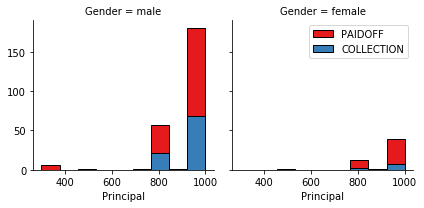

In [9]:
bins = np.linspace(data.Principal.min(), data.Principal.max(), 10)
g = sns.FacetGrid(data, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

<b> Plotting bar graph for age v/s loan_status 

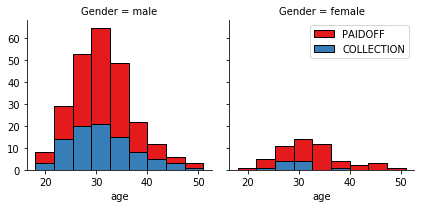

In [10]:
bins = np.linspace(data.age.min(), data.age.max(), 10)
a = sns.FacetGrid(data, col = 'Gender', hue = "loan_status", palette = 'Set1', col_wrap = 2)
a.map(plt.hist, 'age', bins= bins, ec = 'k')

a.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

In [11]:
data['dayofweek'] = data['effective_date'].dt.dayofweek

In [12]:
data['dayofweek'].head()

0    3
1    3
2    3
3    4
4    4
Name: dayofweek, dtype: int64

<b> Plotting graph

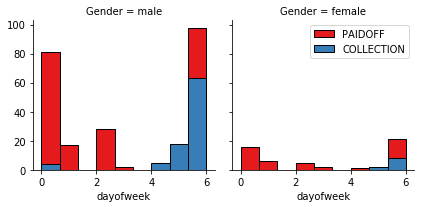

In [13]:
bins = np.linspace(data.dayofweek.min(), data.dayofweek.max(), 10)
c = sns.FacetGrid(data, col = 'Gender', hue = 'loan_status', palette="Set1", col_wrap=2)
c.map(plt.hist,'dayofweek', bins=bins, ec="k")

c.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4

In [14]:
data['weekend'] = data['dayofweek'].apply(lambda x: 1 if x>3 else 0)
data.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


# Convert Categorical features to numerical values

Convert Gender using One Hot encoding

In [15]:
data.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.841270
        COLLECTION     0.158730
male    PAIDOFF        0.732938
        COLLECTION     0.267062
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:

### One Hot Coding

### Education

In [16]:
data.groupby(['education'])['loan_status'].value_counts()

education             loan_status
Bechalor              PAIDOFF         41
                      COLLECTION      11
High School or Below  PAIDOFF        123
                      COLLECTION      49
Master or Above       PAIDOFF          3
                      COLLECTION       1
college               PAIDOFF        133
                      COLLECTION      39
Name: loan_status, dtype: int64

### Feature before One Hot Encoding

In [17]:
data[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,male,High School or Below
1,1000,30,33,female,Bechalor
2,1000,15,27,male,college
3,1000,30,28,female,college
4,1000,30,29,male,college


In [18]:
Feature = data[['Principal','terms','age','weekend']]
Feature = pd.concat([Feature, pd.get_dummies(data[['education', 'Gender']])], axis = 1)
Feature.head()

,Principal,terms,age,weekend,education_Bechalor,education_High School or Below,education_Master or Above,education_college,Gender_female,Gender_male
0,1000,30,45,0,0,1,0,0,0,1
1,1000,30,33,0,1,0,0,0,1,0
2,1000,15,27,0,0,0,0,1,0,1
3,1000,30,28,1,0,0,0,1,1,0
4,1000,30,29,1,0,0,0,1,0,1


In [19]:
Feature.drop(['education_Master or Above'], axis = 1, inplace=True)
Feature.head()

,Principal,terms,age,weekend,education_Bechalor,education_High School or Below,education_college,Gender_female,Gender_male
0,1000,30,45,0,0,1,0,0,1
1,1000,30,33,0,1,0,0,1,0
2,1000,15,27,0,0,0,1,0,1
3,1000,30,28,1,0,0,1,1,0
4,1000,30,29,1,0,0,1,0,1


Encoding y label

In [20]:
Le = LabelEncoder()
data['loan_status'] = Le.fit_transform(data['loan_status'])
data['loan_status'][:15]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
Name: loan_status, dtype: int32

### Feature Selection

In [21]:
X = Feature
X[0:5]

,Principal,terms,age,weekend,education_Bechalor,education_High School or Below,education_college,Gender_female,Gender_male
0,1000,30,45,0,0,1,0,0,1
1,1000,30,33,0,1,0,0,1,0
2,1000,15,27,0,0,0,1,0,1
3,1000,30,28,1,0,0,1,1,0
4,1000,30,29,1,0,0,1,0,1


In [22]:
X.shape

(400, 9)

In [23]:
y = data['loan_status']
y[:15]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
Name: loan_status, dtype: int32

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 346, shuffle = False, random_state=4)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [25]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (346, 9) (346,)
Test set: (54, 9) (54,)


# Normalize Data

In [26]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


array([[ 0.50130175,  0.92089421,  2.31334964, -1.21838912, -0.38655567,
         1.15133896, -0.86855395, -0.43236977,  0.43236977],
       [ 0.50130175,  0.92089421,  0.32194392, -1.21838912,  2.5869495 ,
        -0.86855395, -0.86855395,  2.31283513, -2.31283513],
       [ 0.50130175, -0.9332552 , -0.67375893, -1.21838912, -0.38655567,
        -0.86855395,  1.15133896, -0.43236977,  0.43236977],
       [ 0.50130175,  0.92089421, -0.50780846,  0.82075585, -0.38655567,
        -0.86855395,  1.15133896,  2.31283513, -2.31283513],
       [ 0.50130175,  0.92089421, -0.34185798,  0.82075585, -0.38655567,
        -0.86855395,  1.15133896, -0.43236977,  0.43236977]])

Data Standardization give data zero mean and unit variance

# K Nearest Neighbor(KNN)

In [27]:
from sklearn.neighbors import KNeighborsClassifier

### Training and Predicting with variable k

In [28]:
ks = 15

mean_acc = np.zeros((ks - 1))
std_acc = np.zeros((ks-1))

In [29]:
for n in range(3, ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X, y)
    y_predicted = neigh.predict(X_test)
    mean_acc[n-1] = jaccard_similarity_score(y_test, y_predicted)
    std_acc[n-1]=np.std(y_predicted==y_test)/np.sqrt(y_predicted.shape[0])

print(mean_acc)

[0.         0.         0.74074074 0.72222222 0.74074074 0.74074074
 0.74074074 0.74074074 0.74074074 0.74074074 0.74074074 0.74074074
 0.74074074 0.74074074]


In [30]:
knn_jaccard = mean_acc.max().round(2)
knn_jaccard

0.74

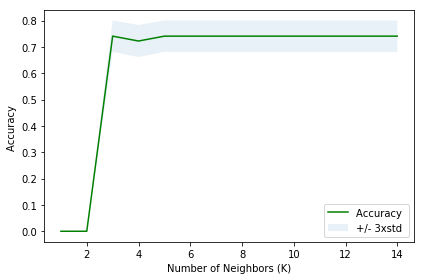

In [31]:
plt.plot(range(1,ks),mean_acc,'g')
plt.fill_between(range(1,ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [32]:
knn_f1_score = f1_score(y_test, y_predicted, average = 'weighted').round(2)
knn_f1_score

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.63

In [33]:
#Log Loss

for n in range(3, ks):
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X, y)
    y_predicted_knn = neigh.predict_proba(X_test)[:,1]

print(y_predicted_knn)

[0.71428571 0.78571429 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.78571429 0.71428571 0.71428571 0.71428571 0.78571429
 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.78571429
 0.71428571 0.78571429 0.71428571 0.78571429 0.78571429 0.71428571
 0.71428571 0.78571429 0.71428571 0.71428571 0.78571429 0.71428571
 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.78571429 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571
 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571 0.71428571]


In [34]:
knn_logloss = log_loss(y_test, y_predicted_knn, eps=1e-15,normalize = True).round(2)
knn_logloss

0.56

# Support Vector Machines(SVM)

In [35]:
from sklearn import svm

data_svm = svm.SVC(kernel = 'rbf', probability = True)

In [36]:
data_svm.fit(X_train, y_train)

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [37]:
ypred_svm = data_svm.predict(X_test)
ypred_svm[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [38]:
acc_jacc_svm = jaccard_similarity_score(ypred_svm, y_test).round(2)
acc_jacc_svm

0.74

In [39]:
acc_f1_svm = f1_score(y_test, ypred_svm, average = 'weighted').round(2)
acc_f1_svm

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.63

In [40]:
# For log loss
ypred_svm_logloss = data_svm.predict_proba(X_test)[:,1]
print(ypred_svm_logloss)

[0.76030483 0.76005699 0.76645606 0.68952395 0.73275817 0.75991717
 0.76825629 0.7853721  0.72202483 0.75523849 0.71454316 0.76005928
 0.78204278 0.73721832 0.71315665 0.76357873 0.77165147 0.76703501
 0.77401565 0.76707809 0.75205153 0.76767278 0.75992338 0.77170788
 0.78043486 0.78050678 0.79287588 0.77606851 0.7986698  0.78765488
 0.78765488 0.78733957 0.78765488 0.77205916 0.78733957 0.78765488
 0.78987586 0.77117559 0.74731792 0.75235788 0.77052507 0.74795684
 0.74570132 0.75205153 0.69088913 0.77664688 0.77401565 0.72656926
 0.75694402 0.77201936 0.76770104 0.72371479 0.73382727 0.79069955]


In [41]:
acc_logloss_svm = log_loss(y_test, ypred_svm_logloss, eps=1e-15,normalize = True).round(2)
acc_logloss_svm

0.56

# Decision Trees

In [42]:
from sklearn.tree import DecisionTreeClassifier

loanTree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
loanTree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [43]:
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [44]:
ypred_tree = loanTree.predict(X_test)
ypred_tree

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1])

In [45]:
acc_jacc_dt = jaccard_similarity_score(ypred_tree, y_test).round(2)
acc_jacc_dt

0.7

In [46]:
acc_f1_dt = f1_score(ypred_tree, y_test, average ='weighted').round(2)
acc_f1_dt

0.72

Finding probabilities for log_loss

In [47]:
ypred_tree_logloss = loanTree.predict_proba(X_test)[:,1]
ypred_tree_logloss

array([1.        , 1.        , 1.        , 0.55102041, 0.58974359,
       0.58974359, 0.55102041, 0.58974359, 0.        , 0.66666667,
       0.        , 1.        , 0.58974359, 0.        , 0.        ,
       0.55102041, 0.4516129 , 1.        , 0.375     , 1.        ,
       0.55102041, 1.        , 1.        , 1.        , 1.        ,
       0.90909091, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.58974359, 1.        , 0.66666667, 0.55102041, 0.        ,
       0.66666667, 0.375     , 1.        , 0.78571429, 0.58974359,
       0.78571429, 0.4516129 , 0.4516129 , 1.        ])

In [48]:
y_test[:15]

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
Name: loan_status, dtype: int32

In [49]:
acc_logloss_dt = log_loss(y_test, ypred_tree_logloss, eps=1e-15, normalize = True).round(2)
acc_logloss_dt

4.78

# Logistic Regression

In [50]:
LR = LogisticRegression(C = 0.01, solver = 'liblinear')

In [51]:
LR.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
ypred_logreg = LR.predict(X_test)
ypred_logreg

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [53]:
acc_jacc_LR = jaccard_similarity_score(ypred_logreg, y_test).round(2)
acc_jacc_LR

0.74

In [54]:
acc_f1_LR = f1_score(ypred_logreg, y_test, average ='weighted').round(2)
acc_f1_LR

C:\Users\DELL\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.85

In [55]:
# Predicting probailities for Log loss

ypred_logreg_logloss = LR.predict_proba(X_test)[:,1]
ypred_logreg_logloss

array([0.84228219, 0.68024363, 0.7734378 , 0.67580741, 0.72492065,
       0.72128757, 0.75216174, 0.70226036, 0.73834196, 0.80864333,
       0.6987356 , 0.68578728, 0.69690861, 0.75114068, 0.7455535 ,
       0.71357785, 0.79009719, 0.83231519, 0.75610379, 0.80772821,
       0.69771281, 0.79969447, 0.74548118, 0.81851715, 0.80228914,
       0.69319775, 0.78734292, 0.81946133, 0.75994598, 0.7464559 ,
       0.7464559 , 0.83955471, 0.7464559 , 0.75124506, 0.83955471,
       0.7464559 , 0.73588027, 0.75293395, 0.79727266, 0.76768485,
       0.70747576, 0.79393031, 0.78648332, 0.69771281, 0.72755142,
       0.63462545, 0.75610379, 0.67786827, 0.72058149, 0.702178  ,
       0.73071981, 0.72810226, 0.75893748, 0.75987411])

In [56]:
acc_logloss_LR = log_loss(y_test, ypred_logreg, eps=1e-15, normalize = True).round(2)
acc_logloss_LR

8.95

# Final Report

In [57]:
finalreport = {'KNN':[knn_jaccard, knn_f1_score, knn_logloss], 'Decision Tree':[acc_jacc_dt, acc_f1_dt, acc_logloss_dt], 'SVM': [acc_jacc_svm, acc_f1_svm, acc_logloss_svm], 'Logistic Regression': [acc_jacc_LR,acc_f1_LR, acc_logloss_LR]}

In [58]:
finalreport

{'Decision Tree': [0.7, 0.72, 4.78],
 'KNN': [0.74, 0.63, 0.56],
 'Logistic Regression': [0.74, 0.85, 8.95],
 'SVM': [0.74, 0.63, 0.56]}

In [59]:
Report = pd.DataFrame(finalreport, index = ['Jacard\'s Index','F1 score','Log loss'])

In [60]:
Report

,Decision Tree,KNN,Logistic Regression,SVM
Jacard's Index,0.70,0.74,0.74,0.74
F1 score,0.72,0.63,0.85,0.63
Log loss,4.78,0.56,8.95,0.56
